In [2]:
from astropy.io import ascii
from astropy.table import Column, join, vstack, setdiff
from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

def condition_1(cen_off, cen_off_std, z, z0=0.228, dz=0.012, thre=1):
    return (cen_off>thre) & (cen_off>3*cen_off_std) & (abs(z-z0)<dz) #& (z>0.22)

def condition_2(cen_off, cen_off_std, z, z0=0.228, dz=0.012, thre=1):
    return (cen_off>thre+3*cen_off_std) & (abs(z-z0)<dz)

In [83]:
subtract = True
sum_type = 'mean'
sn = 2.5
subcon = 'contsub_' if subtract else ''

tab_A2390C = Table.read('./output/A2390C/centroid_analysis_A2390C_%s_sn%.1f_%slpf_NB.txt'%(sum_type, sn, subcon), format='ascii')
tab_A2390E = Table.read('./output/A2390E/centroid_analysis_A2390E_%s_sn%.1f_%slpf_NB.txt'%(sum_type, sn, subcon), format='ascii')
tab_A2390W = Table.read('./output/A2390W/centroid_analysis_A2390W_%s_sn%.1f_%slpf_NB.txt'%(sum_type, sn, subcon), format='ascii')

datacube_C = Read_Datacube('./output/A2390C/A2390C_cube_lpf.fits', 
                           name='A2390C', z0=0.228, mode="MMA",
                           table='./output/A2390C/A2390C_MMA_lpf.dat', 
                           deep_frame='./output/A2390C/A2390C_DF.fits',
                           mask_edge='./output/A2390C/Raw_stack_A2390C_mask.fits')
wcs_C = datacube_C.get_wcs()

datacube_E = Read_Datacube('./output/A2390E/A2390E_cube_lpf.fits',
                           name='A2390E', z0=0.228, mode="MMA",
                           table='./output/A2390E/A2390E_MMA_lpf.dat',
                           deep_frame='./output/A2390E/A2390E_DF.fits')
wcs_E = datacube_E.get_wcs()

datacube_W = Read_Datacube('./output/A2390W/A2390W_cube_lpf.fits', 
                           name='A2390W', z0=0.228, mode="MMA",
                           table='./output/A2390W/A2390W_MMA_lpf.dat', 
                           deep_frame='./output/A2390W/A2390W_DF.fits')
wcs_W = datacube_W.get_wcs()

In [84]:
set_radius(tab_A2390C, datacube_C)
set_radius(tab_A2390E, datacube_E)
set_radius(tab_A2390W, datacube_W)   

# Match with each other
c_A2390C, c_A2390E, c_A2390W = \
        [SkyCoord(tab['ra'], tab['dec'], frame='icrs', unit="deg")
         for tab in [tab_A2390C, tab_A2390E, tab_A2390W]]

idx, d2d, d3d = c_A2390E.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_EC = tab_A2390E[match]
tab_CE = tab_A2390C[idx[match]]

idx, d2d, d3d = c_A2390W.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_WC = tab_A2390W[match]
tab_CW = tab_A2390C[idx[match]]

# Stack table
tab_E, tab_C, tab_W = tab_A2390E.copy(), tab_A2390C.copy(), tab_A2390W.copy()
tab_A2390 = vstack([tab_C, tab_E , tab_W], join_type='inner')

# Remove repeated source with lower SNR
good_E = tab_EC['SN_Ha']>tab_CE['SN_Ha']
id_rm_EC = tab_EC['ID'][~good_E].data
id_rm_CE = tab_CE['ID'][good_E].data

good_W = tab_WC['SN_Ha']>tab_CW['SN_Ha']
id_rm_WC = tab_WC['ID'][~good_W].data
id_rm_CW = tab_CW['ID'][good_W].data

for id_rm in np.concatenate([id_rm_EC, id_rm_WC, id_rm_CW, id_rm_CE]):
    tab_A2390.remove_row(np.where(tab_A2390['ID']==id_rm)[0][0])

In [85]:
tab = tab_A2390.copy()

# OIII
ID_rm = []
for Field in ['C','E','W']:
    dir_V  = glob.glob('./output/A2390%s/pic/candidate_MMA_lpf/C/*'%(Field))
    ID_rm = np.append(ID_rm, np.array([re.compile(r'\d+').findall(el)[-1]+Field for el in dir_V]))
    
# Visual 
ID_rm = np.append(ID_rm, ['440C', '1687C', '1843C', '203E', '637E', '934E', '779W', '890W'])
print(ID_rm)

#Remove non-cluster member
irow_rm = np.array([],dtype=int)
for id in ID_rm:
    irow_rm = np.append(irow_rm, np.argwhere(tab['ID']==id))
tab.remove_rows(irow_rm)

not_edge = (tab["X"]>=100) & (tab["X"]<=(2064-100)) & (tab["Y"]>=100) & (tab["Y"]<=(2048-100))
has_offset = tab['cen_offset_ISO-D'] > 3 * tab['cen_offset_std_ISO-D']
cond = not_edge & has_offset
tab = tab[cond]
tab[:5]

['6C' '119C' '124C' '197C' '411C' '499C' '702C' '828C' '868C' '972C'
 '1248C' '1264C' '289E' '432E' '686E' '757E' '1279E' '1340E' '1420E'
 '1581E' '997W' '440C' '1687C' '1843C' '203E' '637E' '934E' '779W' '890W']


/home/qliu/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


ID,ra,dec,z,X,Y,SN_Ha,SN_OIII,SN_OII,diff_angle_ISO-D,cen_offset_ISO-D,diff_angle_std_ISO-D,cen_offset_std_ISO-D,pa_ISO-D,diff_angle_ISO-Dm,cen_offset_ISO-Dm,diff_angle_std_ISO-Dm,cen_offset_std_ISO-Dm,pa_ISO-Dm,clus_cen_angle,dist_clus_cen,radius
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
212C,328.3937,17.607,0.25,1087.34,333.52,49.554,18.655,19.659,50.622,0.535,0.969,0.009,315.383,48.549,0.573,12.605,0.126,317.455,6.004,994.691,7.96
234C,328.4138,17.6097,0.2309,874.57,361.27,26.386,16.515,22.849,120.935,1.544,0.703,0.018,232.54,125.084,1.809,7.65,0.241,228.391,353.475,965.379,7.96
349C,328.3927,17.6227,0.2245,1096.38,511.03999999999996,15.392,7.171,8.689,101.906,0.474,1.466,0.013,109.943,111.708,0.806,22.473,0.316,119.745,8.037,821.039,3.95
398C,328.3865,17.6287,0.2501,1161.87,578.63,50.985,11.898,13.452,172.449,0.852,0.277,0.004,201.228,163.455,0.851,10.513,0.156,210.222,13.677,767.827,3.95
417C,328.4255,17.6318,0.2502,749.11,607.85,24.369,22.592,21.334,148.633,0.333,4.521,0.042,193.116,161.75,0.5,44.68,0.39,180.0,341.75,749.35,6.15


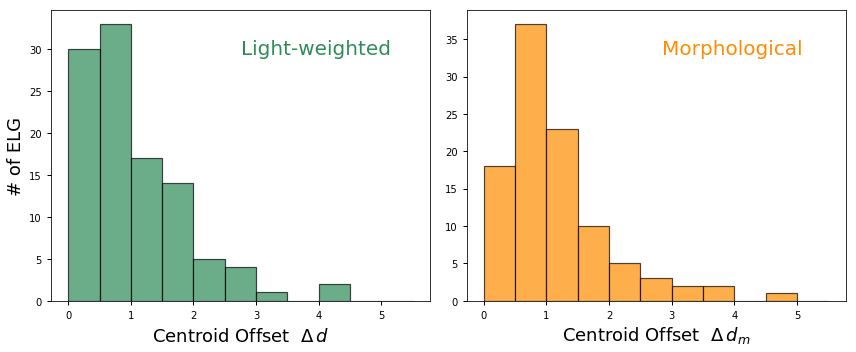

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
props = zip(['seagreen', 'darkorange'], ['','m'],
             ['Light-weighted', 'Morphological'],
             ['cen_offset_ISO-D','cen_offset_ISO-Dm'])
for ax, (color, sub, txt, key) in zip([ax1,ax2], props):
    cen_offset = tab[key]
    ax.hist(cen_offset, bins=np.arange(0,6,0.5),
             color=color, edgecolor='black', linewidth=1.2, alpha=.7)
    ax.set_xticks(np.arange(0,5.5,1))
    ax.text(0.7, 0.85, txt, color=color, ha='center',transform=ax.transAxes, fontsize=20)
    ax.set_xlabel("Centroid Offset  $\Delta\,d_{%s}$"%sub, fontsize=18)
    
ax1.set_ylabel("# of ELG", fontsize=18)
plt.tight_layout()
plt.savefig('./pic/centroid_offset_A2390SN2.5.pdf')

In [86]:
import astropy.units as u
import astropy.constants as c

def V_esc(R, R_vir=1.55*u.Mpc, M_vir=1e14*c.M_sun, C=6):
    s = R/R_vir
    v_esc = np.sqrt(2*c.G*M_vir*K(s,C)/R_vir).to(u.km/u.s)
    return v_esc
    
def K(s,C=6):
    return g_c(C)*np.log(1+C*s)/s

def g_c(C):
    return 1./(np.log(1+C)-C/(1+C))

def Sigma_vir(R_vir, M_vir):
    return np.sqrt(c.G*M_vir/R_vir).to(u.km/u.s)

from astropy.cosmology import FlatLambdaCDM
h = 0.7
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3)
distance_cluster = cosmo.angular_diameter_distance(z=0.228)
print("Distance to cluster: ", np.around(distance_cluster,2))

len_1arc = distance_cluster*u.arcsec.to(u.rad)
len_pix = len_1arc * 0.322  #pixel length in Mpc
print("Length of a pix", np.around(len_pix.to(u.kpc),2))
print("1 kpc = %.3f pix"%np.around((1/len_pix.to(u.kpc)).value,2))

v_vir = 1100 * u.km/u.s #velocity_dispersion
R_vir = 1.51/h * u.Mpc
sigma_v = Sigma_vir(R_vir=R_vir, M_vir=2e15*c.M_sun)
print("R_vir, v_vir:", np.around(R_vir,2), v_vir)
print("sigma_v:", np.around(sigma_v,2))

l_R200 = (len_pix/R_vir).value # pixel length in R200 (1 pix = l R_vir)

rr = np.linspace(0.001,10,100) *u.Mpc
vv = V_esc(rr, R_vir=R_vir, M_vir=2e15*c.M_sun, C=4) # C from Allen2000
v_esc = lambda r: V_esc(r, R_vir=R_vir, M_vir=2e15*c.M_sun, C=4)

def separate_member_space(table, cond, z0=0.228, 
                          v_vir=v_vir, l_R200=l_R200,
                          centroid_type='ISO-D', bound_type="inv-sq",
                          r1=1., v1=1., r2=2., v2=3.):
    r_norm = np.array(table['dist_clus_cen']) * l_R200  # normed distance in R200
    v_norm = (abs(np.array(table['z'])-z0) * 3e5*u.km/u.s / v_vir).value # normed vel in v_vir (sigma_vir)
    
    d_cen_v = table['cen_offset'+'_'+centroid_type]
    d_cen_std_v = table['cen_offset'+'_'+centroid_type]
    d_angle_v = table['diff_angle'+'_'+centroid_type]
    
    vv = v_esc(r_norm*R_vir)
    
    if bound_type == "escape":
        in_cluster = v_norm < (vv/sigma_v)   # escape vel
    elif bound_type == "inv-sq":
        in_cluster = ((v_norm/v1) < 1.5*(r_norm/r1)**(-0.5))   # inv-square
    
    cond1 = cond & (d_angle_v<=90) & in_cluster
    cond2 = cond & (d_angle_v>90) & in_cluster
    conds_angle = cond1, cond2
    
    virial = ((r_norm/r1)**2 + (v_norm/v1)**2) <= 1.
    non_virial = (~virial) & in_cluster
    inner = ((r_norm/r1)**2 <= 1.) & in_cluster
    outer = ((r_norm/r1)**2 > 1.) &  in_cluster
    
    conds_clus = [virial, inner, in_cluster]
    
    return r_norm, v_norm, conds_angle, conds_clus

def draw_phase_diagram(r_norm, v_norm, conds_angle, conds_clus,
                       r1=1., v1=1., r2=2., v2=3., bound_type="inv-sq",
                       thre=1, ft=22, add_text=True, ID=None, ax=None): 
    
    cond1, cond2 = conds_angle
    virial, inner, in_cluster = conds_clus
    non_virial = (~virial) & in_cluster
    
    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.subplot(111)   
    plt.scatter(r_norm[~(cond1|cond2)& in_cluster],
                v_norm[~(cond1|cond2)& in_cluster], s=150, color="gray",
                edgecolor="gray",alpha=0.8,zorder=3, label=None)
    plt.scatter(r_norm[cond1], v_norm[cond1], s=250, color="steelblue",
                edgecolor="k",alpha=0.8,zorder=3,
                label="$\Delta\,d>%.2g$ pix , $\\theta<90^\circ$"%thre)
    plt.scatter(r_norm[cond2], v_norm[cond2], s=250, color="firebrick",
                edgecolor="k",alpha=0.8,zorder=3,
                label="$\Delta\,d>%.2g$ pix , $\\theta>90^\circ$"%thre)
    
    condA = non_virial & (r_norm<=1) 
    condB = virial  
    condC = non_virial & (r_norm>1)   

    condA1, condB1, condC1 = condA&cond1, condB&cond1, condC&cond1  
    condA2, condB2, condC2 = condA&cond2, condB&cond2, condC&cond2 
                  
    plt.text(0.76, 0.94,"A :",color="k",ha="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.76, 0.86,"B :",color="k",ha="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.76, 0.78,"C :",color="k",ha="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.94,"%d"%(np.sum(condA1)),color="steelblue",ha="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.86,"%d"%(np.sum(condB1)),color="steelblue",ha="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.78,"%d"%(np.sum(condC1)),color="steelblue",ha="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.92, 0.94,"%d"%(np.sum(condA2)),color="firebrick",ha="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.92, 0.86,"%d"%(np.sum(condB2)),color="firebrick",ha="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.92, 0.78,"%d"%(np.sum(condC2)),color="firebrick",ha="center",fontsize=ft,transform=ax.transAxes)

    from matplotlib.patches import Ellipse
    ellipse1 = patches.Ellipse(xy=(0,0), width=2*r1, height=2*v1,
                               fc='wheat', lw=4, alpha=0.9, zorder=2)
    ellipse2 = patches.Ellipse(xy=(0,0), width=2*r1, height=2*v1,
                               edgecolor='orange', fc='none', lw=5, alpha=0.9, zorder=2)
    [ax.add_patch(p) for p in [ellipse1, ellipse2]]

    df = pd.read_csv("/home/qliu/Downloads/Jaffe2018a.csv",header=None)  #Jaffe2018
    r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
    plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
             color="y", lw=5,ls="-",alpha=0.5)

    df = pd.read_csv("/home/qliu/Downloads/Jaffe2018b.csv",header=None)  #Jaffe2018
    r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
    plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
             color="m", lw=5,ls="-",alpha=0.5)

    xx = np.linspace(0.001, 2.01*R_vir.value) * u.Mpc
    if bound_type == "escape":
        plt.fill_between(xx/R_vir, y1=v_esc(xx)/sigma_v, y2=0,color='seagreen',alpha=0.2,zorder=1)
        plt.plot(rr/R_vir, vv/sigma_v, color="k",lw=4,ls="-")
        ymax = v_esc(R_vir)/sigma_v
    elif bound_type == "inv-sq":
        plt.fill_between(xx, y1=1.5*(xx)**(-0.5), y2=0,color='seagreen',alpha=0.2,zorder=1)
        plt.plot(rr/R_vir, 1.5*(rr/R_vir)**(-0.5), color="k",lw=4,ls="-")
        ymax = 1.5
    plt.vlines(1, ymin=0.01, ymax=ymax, color="k", alpha=0.9, lw=4, zorder=2)
    
    if add_text:
        for k, (r, v) in enumerate(zip(r_norm, v_norm)):
            if (r>0) & (cond1[k] | cond2[k]) & in_cluster[k]: 
                plt.text(r+np.random.random()*0.05, v+np.random.random()*0.05,
                         ID[k], fontsize=8)
                
    plt.text(0.05, 0.84,r"$\bf A$",color="k",va="center",fontsize=25,transform=ax.transAxes)
    plt.text(0.05, 0.22,r"$\bf B$",color="k",va="center",fontsize=25,transform=ax.transAxes)
    plt.text(0.88, 0.1,r"$\bf C$",color="k",va="center",fontsize=25,transform=ax.transAxes)

    plt.xlim(-0.01, r2+0.05), plt.ylim(-0.005, v2+0.01)
    plt.xticks(fontsize=14), plt.yticks(fontsize=14)
    plt.xlabel("r / R$_{200}$",fontsize=18)
    plt.ylabel("|v$_{los}$ - v$_0$| / $\sigma_{vir}$",fontsize=18)
    plt.legend(loc=9,fontsize=14)
    
    plt.tight_layout()

Distance to cluster:  752.89 Mpc
Length of a pix 1.18 kpc
1 kpc = 0.850 pix
R_vir, v_vir: 2.16 Mpc 1100.0 km / s
sigma_v: 1996.9 km / s


/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater


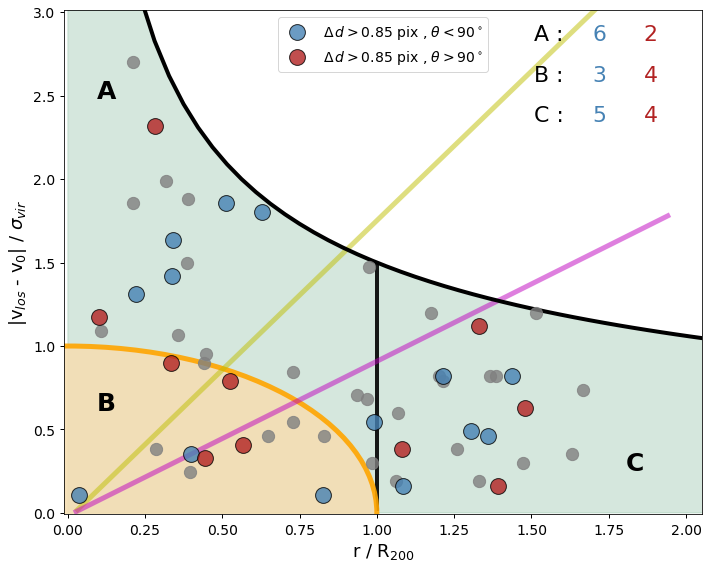

In [87]:
# SN 2.0
cond_func = condition_1
thre = 0.85
cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'],
                     tab['z'], thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_iso,
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, bound_type="inv-sq",
                   thre=thre, add_text=False, ID=tab["ID"])
plt.savefig('./pic/phase_A2390SN2.5.pdf')

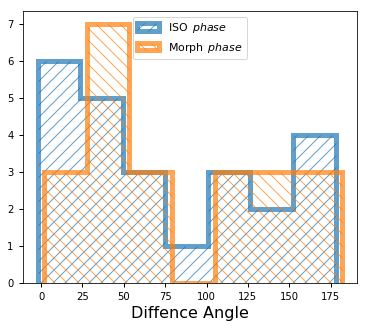

In [88]:
plt.figure(figsize=(6,5))

cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,8)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,8)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(loc=9,fontsize=11)

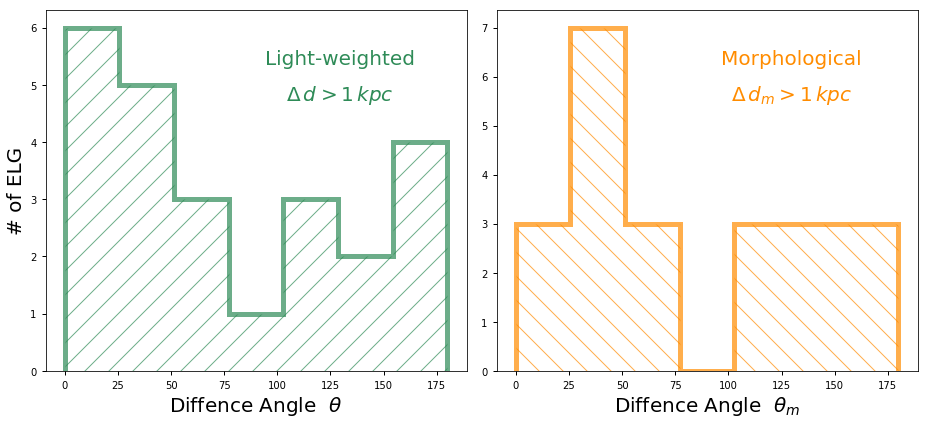

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
props = zip(['/', '\\'], ['','m'], ['seagreen', 'darkorange'],
            ['Light-weighted', 'Morphological'])
for ax, (hat, sub, color, txt), d_angle in zip([ax1,ax2], props,
                                           [d_angle_iso, d_angle_mor]):
    ax.hist(d_angle, histtype="step", bins=np.linspace(0,180,8),
             color=color, linewidth=1.2, hatch=hat, lw=5, alpha=0.7,zorder=2)

    ax.text(0.7,0.85, txt, color=color, ha='center', transform=ax.transAxes, fontsize=20)
    ax.text(0.7,0.75, '$\Delta\,d_{%s}>1\,kpc$'%sub, color=c, ha='center', transform=ax.transAxes, fontsize=20)
    ax.set_xlabel(r'Diffence Angle  $\theta_{%s}$'%sub, fontsize=20)

ax1.set_ylabel("# of ELG", fontsize=20)
plt.tight_layout()
# plt.savefig('./pic/A2390_angle_hist_SN2.5.pdf')

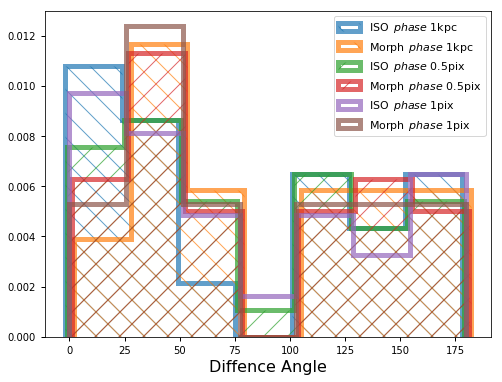

In [55]:
# SN=2.0 mean condition 1
plt.figure(figsize=(8,6))

plt.hist(d_angle_iso_a-2, histtype="step", bins=np.linspace(0,180,8)-2, hatch="\\", lw=5, alpha=0.7,
        label='ISO $\,phase$ 1kpc',density=True, zorder=2)
plt.hist(d_angle_mor_a+2, histtype="step", bins=np.linspace(0,180,8)+2, hatch="\\", lw=5, alpha=0.7,
        label='Morph $\,phase$ 1kpc',density=True, zorder=2)

plt.hist(d_angle_iso_b-1, histtype="step", bins=np.linspace(0,180,8)-1, hatch="/", lw=5, alpha=0.7,
        label='ISO $\,phase$ 0.5pix',density=True, zorder=2)
plt.hist(d_angle_mor_b+1, histtype="step", bins=np.linspace(0,180,8)+1, hatch="/", lw=5, alpha=0.7,
        label='Morph $\,phase$ 0.5pix',density=True, zorder=2)

plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,8), hatch="", lw=5, alpha=0.7,
        label='ISO $\,phase$ 1pix',density=True, zorder=2)
plt.hist(d_angle_mor, histtype="step", bins=np.linspace(0,180,8), hatch="", lw=5, alpha=0.7,
        label='Morph $\,phase$ 1pix',density=True, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(ncol=1, loc=1,fontsize=11)
plt.savefig('./pic/A2390_angle_hist_SN2.5_diff.png')

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater


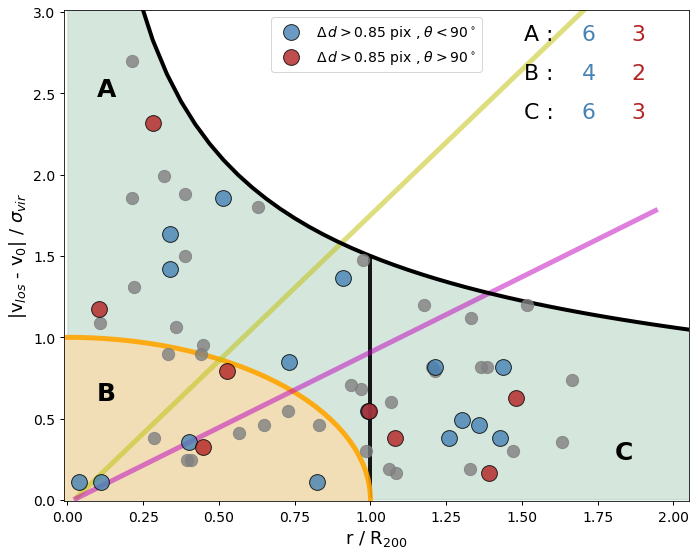

In [432]:
# SN 2.0
cond_func = condition_1
thre = 0.85
cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'],
                     tab['z'], thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_iso,
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, bound_type="inv-sq",
                   thre=thre, add_text=False, ID=tab["ID"])
# plt.savefig('./pic/phase_A2390.pdf')

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less_equal
/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater


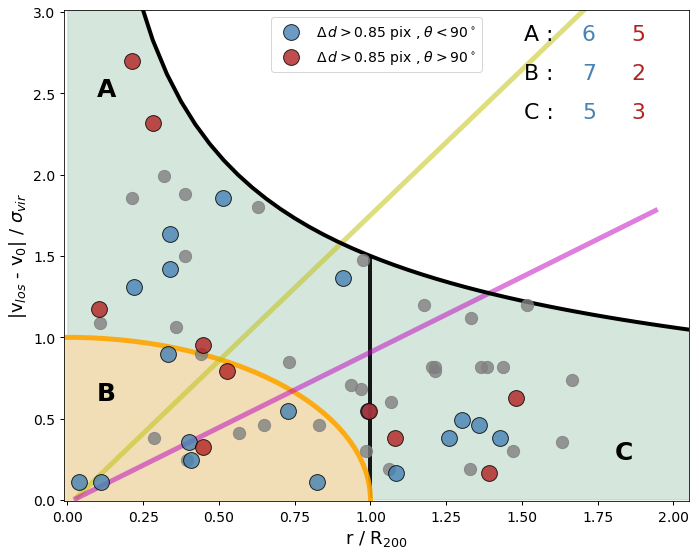

In [433]:
# SN 2.0
cond_func = condition_1
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_mor,
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, bound_type="inv-sq",
                   thre=thre, add_text=False, ID=tab["ID"])
# plt.savefig('./pic/phase_A2390_m.pdf')

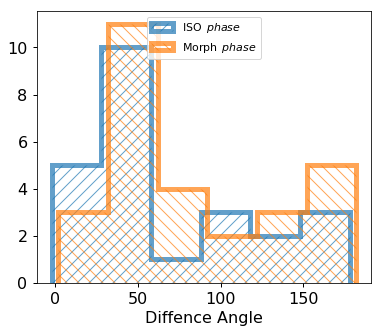

In [175]:
plt.figure(figsize=(6,5))

cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(loc=9,fontsize=11)

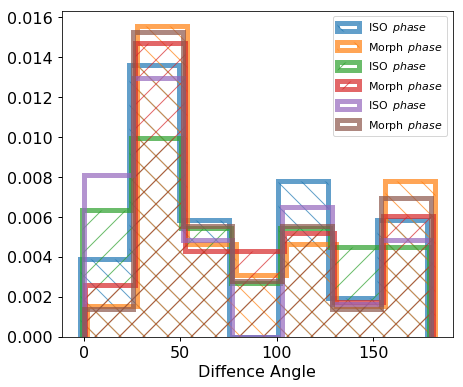

In [162]:
# SN=2.0 mean condition 1
plt.figure(figsize=(7,6))

plt.hist(d_angle_iso_a-2, histtype="step", bins=np.linspace(0,180,8)-2, hatch="\\", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor_a+2, histtype="step", bins=np.linspace(0,180,8)+2, hatch="\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.hist(d_angle_iso_b-1, histtype="step", bins=np.linspace(0,180,8)-1, hatch="/", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor_b+1, histtype="step", bins=np.linspace(0,180,8)+1, hatch="/", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,8), hatch="", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor, histtype="step", bins=np.linspace(0,180,8), hatch="", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(ncol=1, loc=1,fontsize=11)

In [71]:
header = fits.getheader('./mosaic/J215334.00+174010.0-g.fits')
wcs = WCS(header)

coords_field = np.vstack([[coord.ra.value, coord.dec.value]
                    for coord in [SkyCoord(dc.header["TARGETR"], dc.header["TARGETD"], unit=(u.hourangle,u.deg))
                                           for dc in [datacube_C, datacube_E, datacube_W]]])
cen_field = wcs.all_world2pix(coords_field, 0)

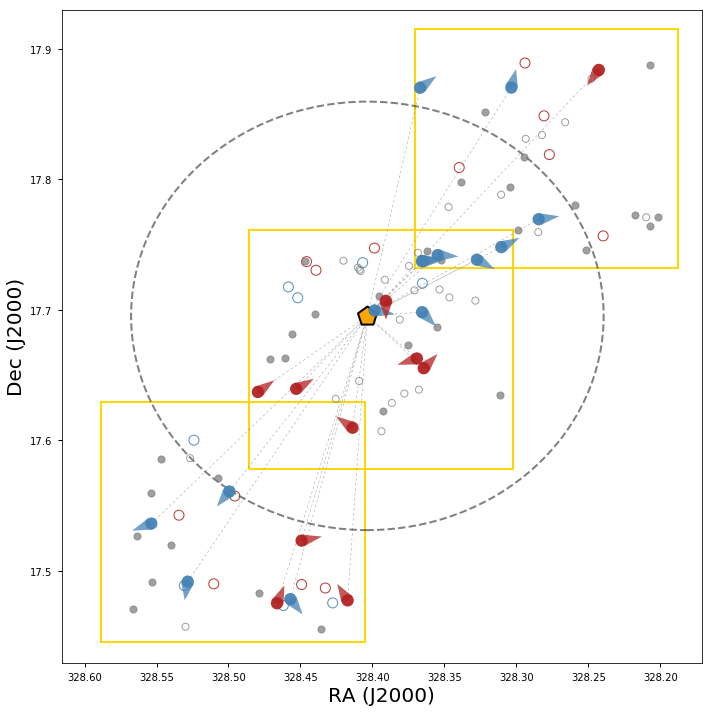

In [89]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(tab['ra'].max() + 0.015, tab['ra'].min() - 0.015)
ax.set_ylim(tab['dec'].min() - 0.015, tab['dec'].max() + 0.015)
ax.set_xlabel("RA (J2000)", fontsize=20)
ax.set_ylabel("Dec (J2000)", fontsize=20)

coord_BCG = (328.40351201,17.69544013)

plt.scatter(coord_BCG[0], coord_BCG[1], s=400, marker='p', edgecolor="k", color="orange", lw=2, alpha=1,zorder=2)

circle = plt.Circle(coord_BCG, R_vir/len_pix*0.322/3600, color='k', ls="--", lw=2., alpha=0.5, fill=False)
ax.add_artist(circle)
for k, (ID, x, y, pa, theta) in enumerate(zip(tab['ID'], tab['ra'], tab['dec'],
                                              tab['pa_ISO-D'], tab['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso & in_cluster)[k]:
        plt.scatter(x, y, s=150, color=color, edgecolors="none", alpha=0.95,zorder=3)
        plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
        plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  fc=color, ec='none', width=0.003, lw=0.5, alpha=0.75, zorder=3)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2Q)*0.002,'#'+ID,color='k',fontsize=8)
    elif (cond_iso & (~in_cluster))[k]:
        plt.scatter(x, y, s=100, facecolors="none", edgecolors=color, alpha=0.9,zorder=2)
#         plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
#         plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
#                   ec=color, width=0.002, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=7)
    elif theta>0:
        if (in_cluster)[k]:
            plt.scatter(x, y, s=50, color="gray", alpha=0.75, zorder=2)
        else:
            plt.scatter(x, y, s=50, facecolor='none', color="gray", alpha=0.75, zorder=2)

L_field = 1024*len_pix/distance_cluster*180/np.pi
for cen in coords_field:
    rec = patches.Rectangle((cen[0]-L_field, cen[1]-L_field), 2*L_field, 2*L_field,
                            linewidth=2, edgecolor='gold', facecolor='none', zorder=1)
    ax.add_patch(rec)

p1, p2, p3, p4 = wcs.calc_footprint()
plt.xlim(p1[0]-0.04, p3[0]+0.04)
plt.ylim(p1[1]+0.01, p2[1]+0.01)
plt.tight_layout()
plt.savefig('./pic/spatial_A2390_SN2.5.pdf')

Continuum non-subtracted

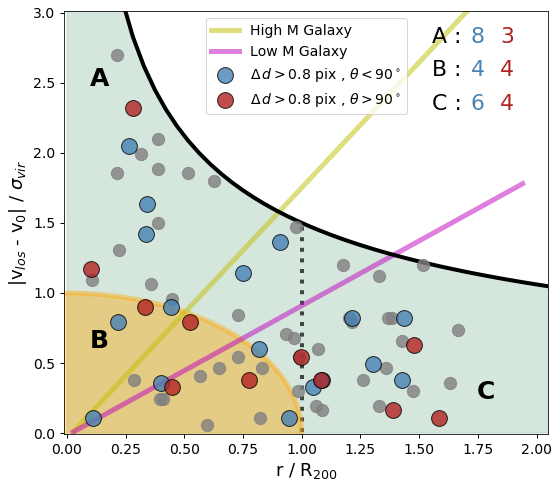

In [286]:
# SN 2.0 mean continuum non-subtracted
cond_func = condition_1
thre = 0.85
cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1kpc

r_n, v_n, conds_angle, conds_clus = separate_member_space(tab, cond_iso,
                                                          bound_type="inv-sq",
                                                          centroid_type='ISO-D')
virial, inner, in_cluster = conds_clus
draw_phase_diagram(r_n, v_n, conds_angle, conds_clus, bound_type="inv-sq",
                   thre=thre, add_text=False)

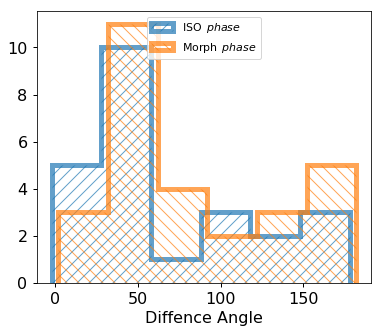

In [434]:
plt.figure(figsize=(6,5))

cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(loc=9,fontsize=11)

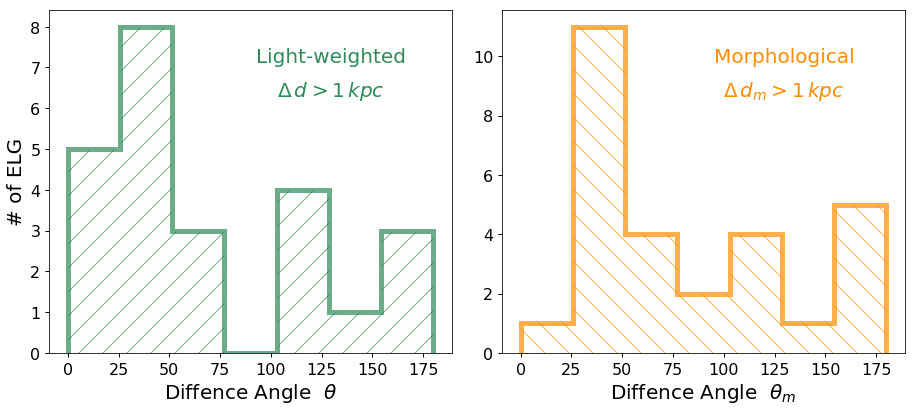

In [438]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
props = zip(['/', '\\'], ['','m'], ['seagreen', 'darkorange'],
            ['Light-weighted', 'Morphological'])
for ax, (hat, sub, c, txt), d_angle in zip([ax1,ax2], props,
                                           [d_angle_iso, d_angle_mor]):
    ax.hist(d_angle, histtype="step", bins=np.linspace(0,180,8),
             color=c, linewidth=1.2, hatch=hat, lw=5, alpha=0.7,zorder=2)

    ax.text(0.7,0.85, txt, color=c, ha='center', transform=ax.transAxes, fontsize=20)
    ax.text(0.7,0.75, '$\Delta\,d_{%s}>1\,kpc$'%sub, color=c, ha='center', transform=ax.transAxes, fontsize=20)
    ax.set_xlabel(r'Diffence Angle  $\theta_{%s}$'%sub, fontsize=20)

ax1.set_ylabel("# of ELG", fontsize=20)
plt.tight_layout()
plt.savefig('./pic/A2390_angle_hist.pdf')

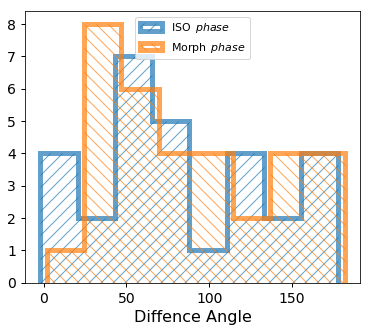

In [287]:
plt.figure(figsize=(6,5))

cond_iso = cond_func(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = cond_func(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,9)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,9)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(loc=9,fontsize=11)

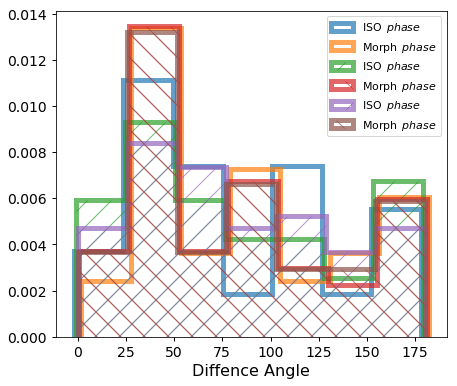

In [152]:
# SN=2.0 mean condition 1
plt.figure(figsize=(7,6))

plt.hist(d_angle_iso_a-2, histtype="step", bins=np.linspace(0,180,8)-2, hatch="", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor_a+2, histtype="step", bins=np.linspace(0,180,8)+2, hatch="", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.hist(d_angle_iso_b-1, histtype="step", bins=np.linspace(0,180,8)-1, hatch="/", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor_b+1, histtype="step", bins=np.linspace(0,180,8)+1, hatch="\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,8), hatch="/", lw=5, alpha=0.7,
        label='ISO $\,phase$',density=True, zorder=2)
plt.hist(d_angle_mor, histtype="step", bins=np.linspace(0,180,8), hatch="\\", lw=5, alpha=0.7,
        label='Morph $\,phase$',density=True, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)

plt.legend(ncol=1, loc=1,fontsize=11)

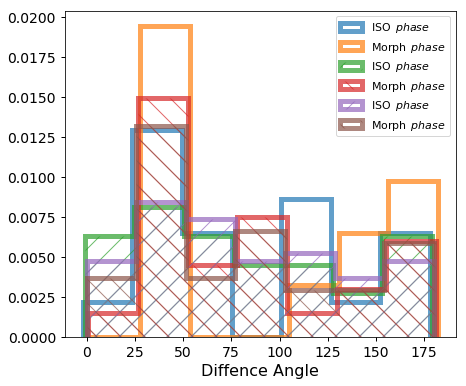

In [144]:
# SN=2.0 mean condition 2

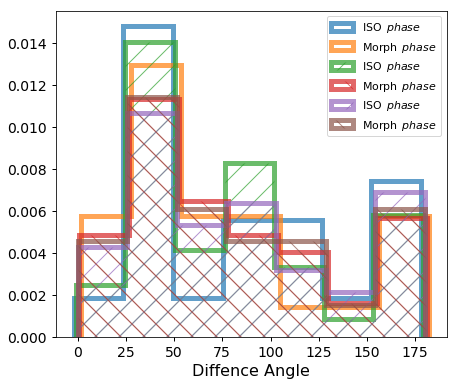

In [164]:
# SN=2.0 weighted condition 1

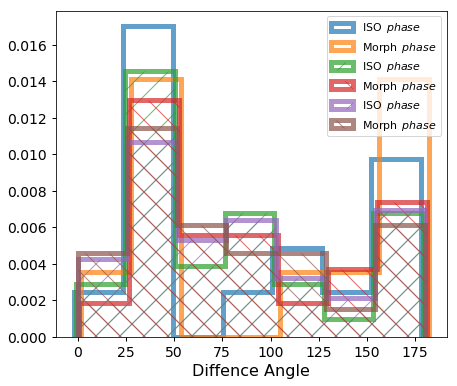

In [176]:
# SN=2.0 weighted condition 2

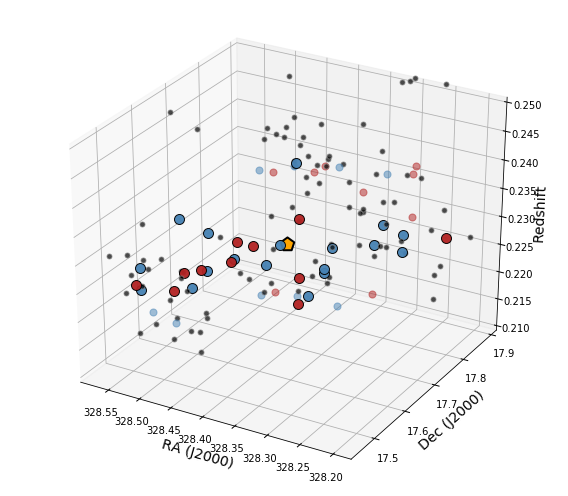

In [341]:
# %matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(tab['ra'].max() + 0.02, tab['ra'].min() - 0.02)
ax.set_ylim(tab['dec'].min() - 0.02, tab['dec'].max() + 0.02)
ax.set_zlim(0.21,0.25)
ax.set_xlabel("RA (J2000)", fontsize=14)
ax.set_ylabel("Dec (J2000)", fontsize=14)
ax.set_zlabel("Redshift", fontsize=14)

coord_BCG = (328.40351201,17.69544013)

ax.scatter(coord_BCG[0], coord_BCG[1], 0.228, s=200, marker='p', color="orange", edgecolor="k", lw=2, alpha=1,zorder=2)

for k, (ID, x, y, z, pa, theta) in enumerate(zip(tab['ID'], tab['ra'], tab['dec'], tab['z'],
                                               tab['pa_ISO-D'], tab['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso& in_cluster)[k]:
        ax.scatter(x, y, z, s=100, color=color, edgecolors="none", alpha=0.95,zorder=4)
#         ax.plot((coord_BCG[0],x), (coord_BCG[1],y), (0.228,z), color="gray", ls="--", dashes=(5,5), lw=.5, alpha=0.8, zorder=1)
#         ax.arrow(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
#                   color=color, width=0.0025, lw=0.01, alpha=0.7, zorder=2)
        ax.quiver(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
                  color=color, length=0.1, alpha=0.7, zorder=4)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=8)
    elif (cond_iso & (~in_cluster))[k]:
        ax.scatter(x, y, z, s=50,  color=color, alpha=0.5,zorder=3)
#         ax.arrow(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
#                   ec=color, fc="none", width=0.002, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=7)
    elif theta>0:
        ax.scatter(x, y, z, s=25, facecolor='none', color="gray", alpha=0.7, zorder=2)
plt.tight_layout()

# A2465C

In [90]:
datacube_D = Read_Datacube('./output/A2465C/A2465C_cube_lpf.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./output/A2465C/A2465C_MMA_lpf.dat',
                         deep_frame='./output/A2465C/A2465C_DF.fits',
                         seg_map='./output/A2465C/A2465C_segm_MMA_lpf.fits',
                         mask_edge='./output/A2465C/Raw_stack_A2465C_mask.fits')

datacube_D.get_wcs()
datacube_D.read_cluster_boundary("./A2465C/A2465C_bound_v2.fits")
datacube_D.src_map = fits.open('./output/A2465C/A2465C_MMA_lpf.fits')[0].data
datacube_D.read_spec('./output/A2465C/A2465C-spec-MMA_lpf.fits')
datacube_D.read_template('./output/template/', n_intp=2, name='A2465C')
datacube_D.read_cc_result('./output/A2465C/A2465C-cc-MMA_lpf.pkl')

Z_bound = fits.getdata('./A2465C/A2465C_bound_v2.fits').astype("int")

id_BCG1 = np.argmin((datacube_D.table["xcentroid"]-707)**2 + (datacube_D.table["ycentroid"]-1385)**2)
id_BCG2 = np.argmin((datacube_D.table["xcentroid"]-1446)**2 + (datacube_D.table["ycentroid"]-679)**2)
pos_BCG = np.array(datacube_D.assign_BCG_position(id_BCG=[id_BCG1,id_BCG2]))

Read Emission Line Template:
['./output/template/Template-A2465C_Ha-NII_gauss.fits',
 './output/template/Template-A2465C_Hb-OIII_gauss.fits',
 './output/template/Template-A2465C_OII_gauss.fits']
Read cross-correlation results for A2465C from : ./output/A2465C/A2465C-cc-MMA_lpf.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss']


In [91]:
from astropy.cosmology import FlatLambdaCDM
h = 0.7
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3)
distance_cluster = cosmo.angular_diameter_distance(z=0.245)
print(distance_cluster)

len_1arc = distance_cluster*u.arcsec.to(u.rad)
len_pix = len_1arc * 0.322  #pixel length in Mpc
print(len_pix)
print("1kpc = %.3f pix"%(1/len_pix.to(u.kpc)).value)

v_vir = 1100 * u.km/u.s #velocity_dispersion
R_vir = 1.51/h * u.Mpc
print(R_vir, v_vir)

l_R200 = (len_pix/R_vir).value # pixel length in R200 1 pix = l R_vir

794.562953587183 Mpc
0.0012403922690940134 Mpc
1kpc = 0.806 pix
2.1571428571428575 Mpc 1100.0 km / s


In [99]:
tab_A2465C = Table.read('./output/A2465C/centroid_analysis_A2465C_mean_sn2.5_contsub_lpf_NB.txt', format='ascii')
set_radius(tab_A2465C, datacube_D)

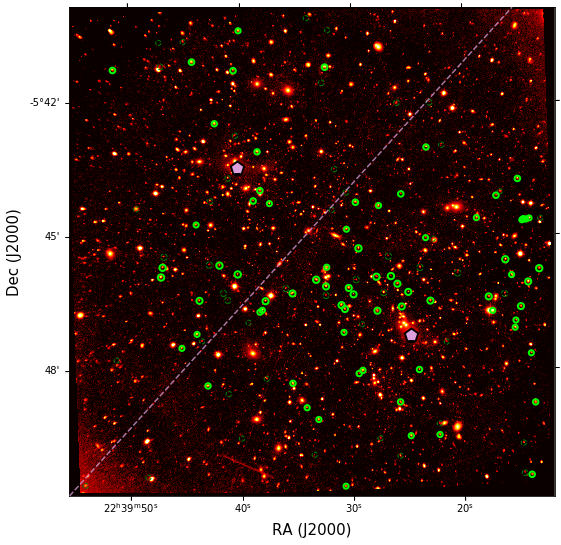

In [100]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111, projection=datacube_D.wcs)
ax.scatter(pos_BCG[:,0], pos_BCG[:,1], s=200, color="plum", edgecolor="k", marker="p", linewidth=2)

plt.scatter(tab_A2465C['X'], tab_A2465C['Y'], s=tab_A2465C['radius']*10+10, facecolor="none", edgecolor="g", linestyle='--')

tab_iso = tab_A2465C[tab_A2465C['cen_offset_ISO-D']>0]
ax.scatter(tab_iso['X'], tab_iso['Y'], s=tab_iso['radius']*10+10, facecolor="none", edgecolor="lime", linewidth=2)
ax.imshow(datacube_D.deep_frame, norm=AsinhNorm(0.01), cmap='hot',
          vmin=np.median(datacube_D.deep_frame), vmax=5e2)

X_bound = np.arange(0,2048,1)
Y_bound = np.argmin(Z_bound, axis=0)
bound = Y_bound>0
plt.plot(X_bound[bound], Y_bound[bound], color='plum', ls='--', alpha=0.75)

plt.xlabel("RA (J2000)", fontsize=15)
plt.ylabel("Dec (J2000)", fontsize=15)

plt.savefig('./pic/A2465_Field_ELG.pdf')

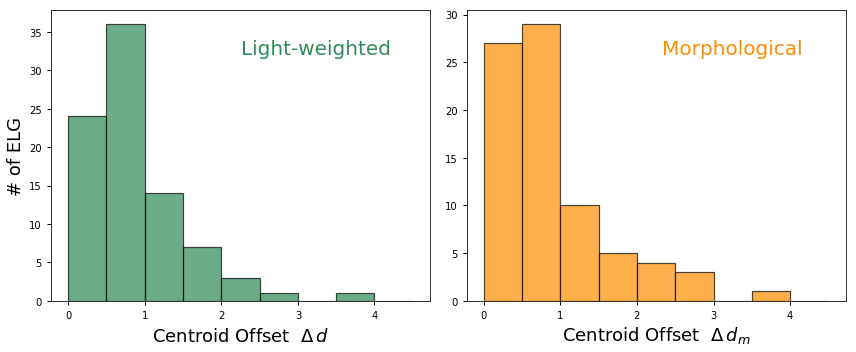

In [96]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
props = zip(['seagreen', 'darkorange'], ['','m'],
             ['Light-weighted', 'Morphological'],
             ['cen_offset_ISO-D','cen_offset_ISO-Dm'])
for ax, (color, sub, txt, key) in zip([ax1,ax2], props):
    cen_offset = tab_A2465C[key]
    ax.hist(cen_offset, bins=np.arange(0,5,0.5),
             color=color, edgecolor='black', linewidth=1.2, alpha=.7)
    ax.set_xticks(np.arange(0,5.,1))
    ax.text(0.7, 0.85, txt, color=color, ha='center',transform=ax.transAxes, fontsize=20)
    ax.set_xlabel("Centroid Offset  $\Delta\,d_{%s}$"%sub, fontsize=18)
    
ax1.set_ylabel("# of ELG", fontsize=18)
plt.tight_layout()
# plt.savefig('./pic/centroid_offset_A2465_SN2.5.pdf')

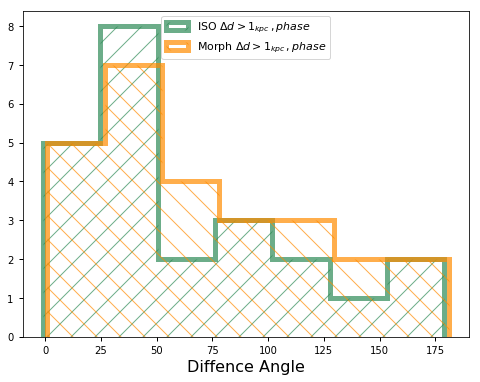

In [102]:
plt.figure(figsize=(8,6))
thre = 0.81
cond_iso = condition_1(tab_A2465C['cen_offset_ISO-D'], tab_A2465C['cen_offset_std_ISO-D'], tab_A2465C['z'],
                       z0=0.245, dz=0.012, thre=thre) # 1 kpc
cond_mor = condition_1(tab_A2465C['cen_offset_ISO-Dm'], tab_A2465C['cen_offset_std_ISO-Dm'], tab_A2465C['z'],
                       z0=0.245, dz=0.012, thre=thre) # 1 kpc

d_angle_iso = tab_A2465C['diff_angle_ISO-D'][cond_iso]
d_angle_mor = tab_A2465C['diff_angle_ISO-Dm'][cond_mor]
plt.hist(d_angle_iso-1, histtype="step", bins=np.linspace(0,180,8)-1,
         linewidth=1.2, hatch="/", lw=5, alpha=0.7,
         color='seagreen', label='ISO $\Delta d>1_{kpc}\,,phase$',zorder=2)
plt.hist(d_angle_mor+1, histtype="step", bins=np.linspace(0,180,8)+1,
         color='darkorange', linewidth=1.2, hatch="\\", lw=5, alpha=0.7,
         label='Morph $\Delta d>1_{kpc}\,,phase$',zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)
plt.legend(loc=9,fontsize=11)

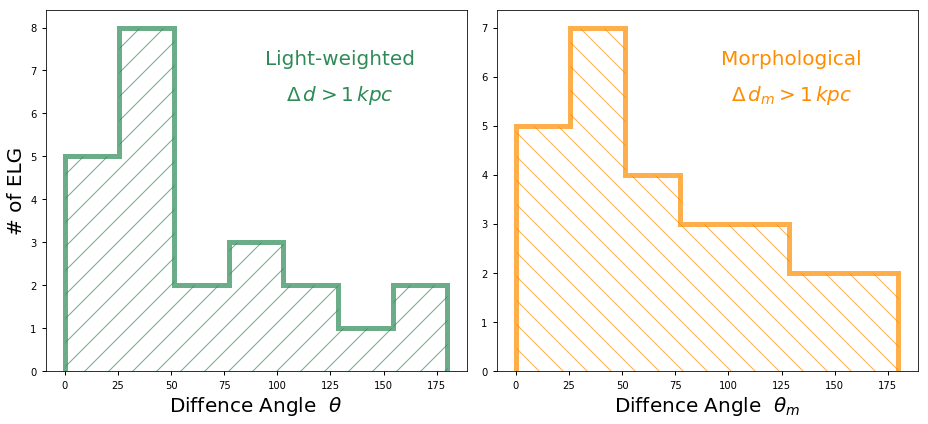

In [104]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
props = zip(['/', '\\'], ['','m'], ['seagreen', 'darkorange'],
            ['Light-weighted', 'Morphological'])
for ax, (hat, sub, c, txt), d_angle in zip([ax1,ax2], props,
                                           [d_angle_iso, d_angle_mor]):
    ax.hist(d_angle, histtype="step", bins=np.linspace(0,180,8),
             color=c, linewidth=1.2, hatch=hat, lw=5, alpha=0.7,zorder=2)

    ax.text(0.7,0.85, txt, color=c, ha='center', transform=ax.transAxes, fontsize=20)
    ax.text(0.7,0.75, '$\Delta\,d_{%s}>1\,kpc$'%sub, color=c, ha='center', transform=ax.transAxes, fontsize=20)
    ax.set_xlabel(r'Diffence Angle  $\theta_{%s}$'%sub, fontsize=20)

ax1.set_ylabel("# of ELG", fontsize=20)
plt.tight_layout()
plt.savefig('./pic/A2465_angle_hist_SN2.5.pdf')

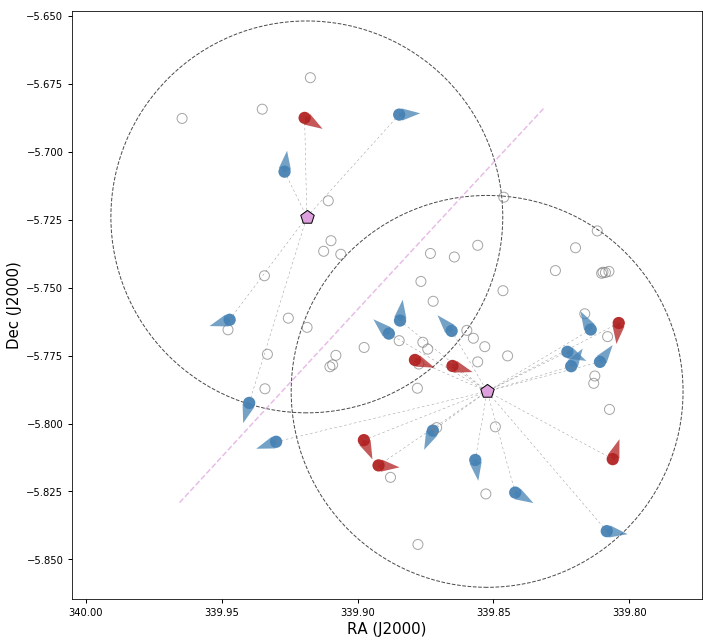

In [106]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(tab_A2465C['ra'].max() + 0.03, tab_A2465C['ra'].min() - 0.03)
ax.set_ylim(tab_A2465C['dec'].min() - 0.02, tab_A2465C['dec'].max() + 0.02)
plt.xlabel("RA (J2000)", fontsize=15)
plt.ylabel("Dec (J2000)", fontsize=15)

coord_BCG = ((339.91869588, -5.72394458), (339.85233922, -5.78816229))
for i, R_v in enumerate([1,1]):
    plt.scatter(coord_BCG[i][0],coord_BCG[i][1], s=200, edgecolor="k", color="plum", marker='p', alpha=1,zorder=3)
    circle = plt.Circle(coord_BCG[i], R_v*u.Mpc/len_pix*0.322/3600, color='k', ls="--", lw=1., alpha=0.7, fill=False) #1 Mpc
    ax.add_artist(circle)
    
plt.imshow(Z_bound, cmap='seismic')

for k, (ID, ra, dec, z, pa, theta) in enumerate(zip(tab_A2465C['ID'], tab_A2465C['ra'], tab_A2465C['dec'], tab_A2465C['z'],
                                                    tab_A2465C['pa_ISO-D'], tab_A2465C['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso & (abs(tab_A2465C['z']-0.245)<=0.012))[k]:
        plt.scatter(ra, dec, s=150, color=color, edgecolors="none", alpha=0.95,zorder=2)

        x, y = datacube_D.wcs.all_world2pix(ra, dec, 0)
        member = Z_bound[np.int(y), np.int(x)] - 1
        plt.plot((ra, coord_BCG[member][0]), (dec,coord_BCG[member][1]), color="gray",
                 ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=2)

        plt.arrow(ra, dec, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  color=color, width=0.0015, lw=0.01, alpha=0.75, zorder=2)
        
    elif (cond_iso & (abs(tab_A2465C['z']-0.245)>0.012))[k]:
        plt.scatter(ra, dec, s=100, facecolors="none", edgecolors=color, alpha=0.9,zorder=2)
    elif theta>0:
        plt.scatter(ra, dec, s=100, facecolor='none', color="gray", alpha=0.7, zorder=2)

bound = (Y_bound>200) & (Y_bound<2048-200)
ra_bound, dec_bound = datacube_D.wcs.all_pix2world(X_bound[bound],Y_bound[bound], 0)
plt.plot(ra_bound, dec_bound, color='plum', ls='--', lw=1.5, alpha=0.7)
plt.tight_layout()
plt.savefig('./pic/spatial_A2465_SN2.5.pdf')